In [1]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

data = load_breast_cancer()
X_train, X_test, y_train, y_test = train_test_split(data.data, data.target, test_size=0.2, random_state=42)


In [2]:
from keras.models import Sequential
from keras.layers import Dense, Dropout

model = Sequential()
model.add(Dense(32, activation='relu', input_dim=X_train.shape[1]))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))


In [3]:
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam

model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
early_stop = EarlyStopping(monitor='val_loss', patience=10)

for i in range(100):
    model.fit(X_train, y_train, epochs=1, batch_size=32, validation_split=0.2, callbacks=[early_stop], verbose=0)
    model.evaluate(X_test, y_test, verbose=0)


In [4]:
import numpy as np
from keras.layers import Dropout

def predict_with_dropout(model, x, n_samples):
    """
    Predict using MC dropout by performing multiple forward passes with dropout during inference.
    """
    result = np.zeros((n_samples, x.shape[0]))
    for i in range(n_samples):
        result[i] = model.predict(x, batch_size=32).flatten()
    return result

n_samples = 100
y_preds = predict_with_dropout(model, X_test, n_samples)
y_mean = np.mean(y_preds, axis=0)
y_std = np.std(y_preds, axis=0)


4/4 [==============================] - 0s 2ms/step


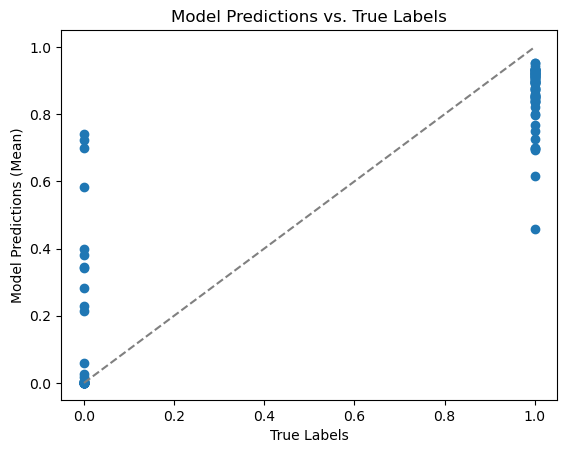

In [5]:
import matplotlib.pyplot as plt

plt.figure()
plt.scatter(y_test, y_mean)
plt.plot([0, 1], [0, 1], '--', color='gray')
plt.xlabel('True Labels')
plt.ylabel('Model Predictions (Mean)')
plt.title('Model Predictions vs. True Labels')
plt.show()


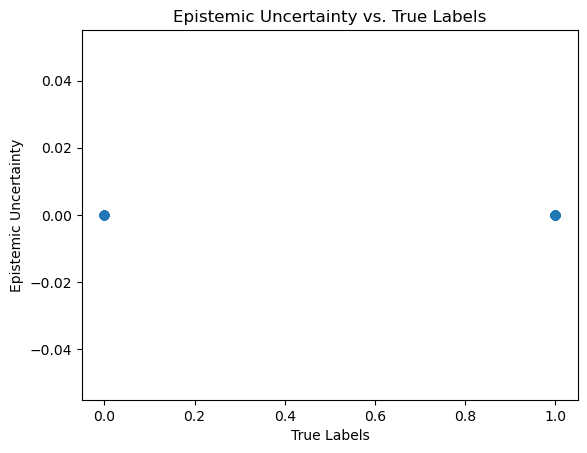

In [6]:
plt.figure()
plt.scatter(y_test, y_std)
plt.xlabel('True Labels')
plt.ylabel('Epistemic Uncertainty')
plt.title('Epistemic Uncertainty vs. True Labels')
plt.show()


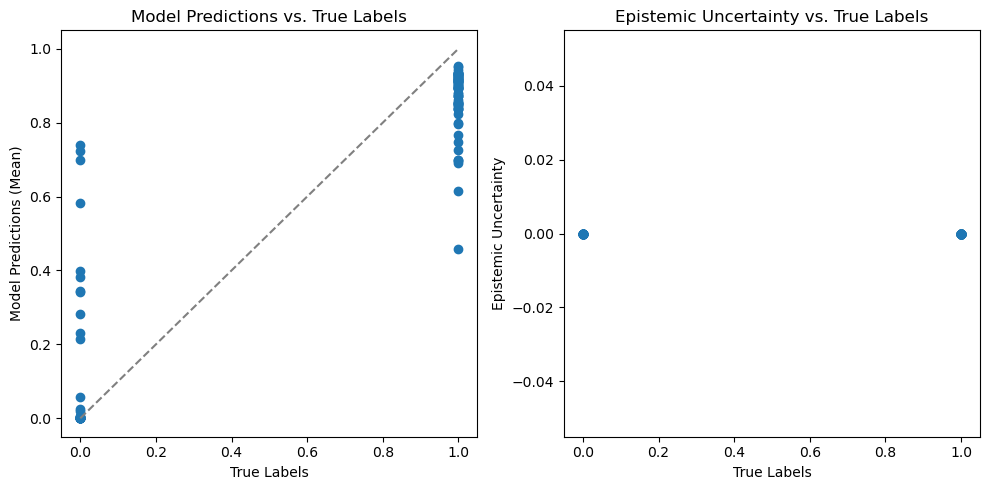

In [7]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.scatter(y_test, y_mean)
plt.plot([0, 1], [0, 1], '--', color='gray')
plt.xlabel('True Labels')
plt.ylabel('Model Predictions (Mean)')
plt.title('Model Predictions vs. True Labels')
plt.subplot(1, 2, 2)
plt.scatter(y_test, y_std)
plt.xlabel('True Labels')
plt.ylabel('Epistemic Uncertainty')
plt.title('Epistemic Uncertainty vs. True Labels')
plt.tight_layout()
plt.show()


[4.59347785e-01 1.30019368e-13 6.51054870e-05 9.51489031e-01
 9.35432434e-01 2.03210629e-06 4.99160067e-13 2.13910446e-01
 9.16467905e-01 8.52740645e-01 8.51445973e-01 1.21942093e-03
 8.38580191e-01 5.83941579e-01 9.02252495e-01 2.30410278e-01
 8.60701263e-01 9.43097055e-01 9.29873466e-01 4.05005380e-07
 3.98592621e-01 8.72666240e-01 1.88335163e-11 9.13309038e-01
 9.21022177e-01 9.19031858e-01 9.21199858e-01 9.34608161e-01
 8.94052804e-01 6.35988590e-14 9.25538361e-01 9.09578025e-01
 7.96692848e-01 6.15399122e-01 9.30549204e-01 8.73288393e-01
 4.42481227e-03 8.46388221e-01 6.38937436e-09 6.92133248e-01
 9.18029428e-01 2.60413941e-02 9.30705249e-01 8.52763653e-01
 9.15497661e-01 8.47991407e-01 9.25547957e-01 8.96905005e-01
 8.36798310e-01 9.08929408e-01 2.21943282e-07 2.24981491e-08
 8.93181503e-01 8.95135522e-01 9.21372056e-01 7.67348170e-01
 9.16186035e-01 8.84131223e-12 7.22286999e-01 9.27788973e-01
 8.51263702e-01 4.39081504e-07 3.47602991e-09 8.38160813e-01
 9.01755154e-01 7.990876

In [1]:
import pymc3 as pm
import theano.tensor as tt
import numpy as np
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Load the breast cancer dataset
data = datasets.load_breast_cancer()
X, y = data.data, data.target

# Preprocess the data
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Define the Bayesian neural network model using PyMC3
n_hidden = 5

with pm.Model() as neural_network:
    # Define the priors for the weights and biases
    weights_in_1 = pm.Normal("w_in_1", 0, sigma=1, shape=(X.shape[1], n_hidden))
    weights_1_2 = pm.Normal("w_1_2", 0, sigma=1, shape=(n_hidden, n_hidden))
    weights_2_out = pm.Normal("w_2_out", 0, sigma=1, shape=(n_hidden,))
    bias_in_1 = pm.Normal("b_in_1", 0, sigma=1, shape=(n_hidden,))
    bias_1_2 = pm.Normal("b_1_2", 0, sigma=1, shape=(n_hidden,))
    bias_2_out = pm.Normal("b_2_out", 0, sigma=1)

    # Build the neural network architecture
    act_1 = pm.math.tanh(pm.math.dot(X_train, weights_in_1) + bias_in_1)
    act_2 = pm.math.tanh(pm.math.dot(act_1, weights_1_2) + bias_1_2)
    act_out = pm.math.sigmoid(pm.math.dot(act_2, weights_2_out) + bias_2_out)

    # Define the likelihood
    out = pm.Bernoulli("out", act_out, observed=y_train)

    # Perform inference
    trace = pm.sample(1000)

# Evaluate the model on the testing set and compute the epistemic uncertainty
with neural_network:
    ppc = pm.sample_posterior_predictive(trace)
    pred = ppc["out"].mean(axis=0) > 0.5
    epistemic_uncertainty = ppc["out"].std(axis=0)
    accuracy = (y_test == pred).mean() * 100

print(f"Accuracy: {accuracy:.2f}%")
print(f"Epistemic uncertainty: {np.mean(epistemic_uncertainty):.4f}")

ModuleNotFoundError: No module named 'pymc3'